# Tensorflow MNIST Classifier demo

This notebook contains an end-to-end demostration of Dioptra that can be run on any modern laptop.
Please see the [example README](README.md) for instructions on how to prepare your environment for running this example.

### Setup

Below we import the necessary Python modules and ensure the proper environment variables are set so that all the code blocks will work as expected,

In [1]:
EXPERIMENT_NAME = "mnist_fgm"
EXPERIMENT_DESC = "applying the fast gradient sign (FGM) attack to a classifier trained on MNIST"
QUEUE_NAME = 'tensorflow_cpu'
QUEUE_DESC = 'Tensorflow CPU Queue'
PLUGIN_FILES = '../task-plugins/dioptra_custom/fgm_mnist_demo/'
MODEL_NAME = "mnist_classifier"

# Default address for accessing the RESTful API service
RESTAPI_ADDRESS = "http://localhost:80"

# Default address for accessing the MLFlow Tracking server
MLFLOW_TRACKING_URI = "http://localhost:35000"

In [2]:
# Import packages from the Python standard library
import importlib.util
import json
import os
import sys
import pprint
import time
import warnings
from IPython.display import display, clear_output
import logging
import structlog
from pathlib import Path

# Filter out warning messages
warnings.filterwarnings("ignore")
structlog.configure(
    wrapper_class=structlog.make_filtering_bound_logger(logging.ERROR),
)

def register_python_source_file(module_name: str, filepath: Path) -> None:
    """Import a source file directly.

    Args:
        module_name: The module name to associate with the imported source file.
        filepath: The path to the source file.

    Notes:
        Adapted from the following implementation in the Python documentation:
        https://docs.python.org/3/library/importlib.html#importing-a-source-file-directly
    """
    spec = importlib.util.spec_from_file_location(module_name, str(filepath))
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
register_python_source_file("scripts", Path("..", "scripts", "__init__.py"))

# Register the examples/scripts directory as a Python module
from scripts.utils import make_tar
from scripts.setup import upload_experiment, run_experiment, delete_all
from dioptra.client import connect_json_dioptra_client
# Set DIOPTRA_RESTAPI_URI variable if not defined, used to connect to RESTful API service
if os.getenv("DIOPTRA_API") is None:
    os.environ["DIOPTRA_API"] = RESTAPI_ADDRESS

# Set MLFLOW_TRACKING_URI variable, used to connect to MLFlow Tracking service
if os.getenv("MLFLOW_TRACKING_URI") is None:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI

In [3]:
def wait_for_job(job, job_name, quiet=False):
    n = 0
    while job['status'] not in ['finished', 'failed']:
        job = client.jobs.get_by_id(job['id'])
        time.sleep(1)
        if not quiet:
            clear_output(wait=True)
            display("Waiting for job." + "." * (n % 3) )
        n += 1
    if not quiet:
        if job['status'] == 'finished':
            clear_output(wait=True)
            display(f"Job finished. Starting {job_name} job.")
        else:
            raise Exception("Previous job failed. Please see tensorflow-cpu logs for details.")
    

### Dataset

We obtained a copy of the MNIST dataset when we ran `download_data.py` script. If you have not done so already, see [How to Obtain Common Datasets](https://pages.nist.gov/dioptra/getting-started/acquiring-datasets.html).
The training and testing images for the MNIST dataset are stored within the `/dioptra/data/Mnist` directory as PNG files that are organized into the following folder structure,

    Mnist
    ├── testing
    │   ├── 0
    │   ├── 1
    │   ├── 2
    │   ├── 3
    │   ├── 4
    │   ├── 5
    │   ├── 6
    │   ├── 7
    │   ├── 8
    │   └── 9
    └── training
        ├── 0
        ├── 1
        ├── 2
        ├── 3
        ├── 4
        ├── 5
        ├── 6
        ├── 7
        ├── 8
        └── 9

The subfolders under `training/` and `testing/` are the classification labels for the images in the dataset.
This folder structure is a standardized way to encode the label information and many libraries can make use of it, including the Tensorflow library that we are using for this particular demo.

### Login to Dioptra and setup RESTAPI client

To connect with the endpoint, we will use a client class defined in the `examples/scripts/client.py` file that is able to connect with the Dioptra RESTful API using the HTTP protocol.
We connect using the client below.
The client uses the environment variable `DIOPTRA_RESTAPI_URI`, which we configured at the top of the notebook, to figure out how to connect to the Dioptra RESTful API.

In [4]:
client = connect_json_dioptra_client()

It is necessary to login to the RESTAPI to be able to perform any functions. Here we create a user if it is not created already, and login with it.

In [5]:
try:
    client.users.create(
        username='pluginuser',
        email='pluginuser@dioptra.nccoe.nist.gov',
        password='pleasemakesuretoPLUGINthecomputer'
    )
except:
    pass # ignore if user exists already

client.auth.login(
    username='pluginuser',
    password='pleasemakesuretoPLUGINthecomputer'
)

{'username': 'pluginuser', 'status': 'Login successful'}

### Upload all the entrypoints in the src/ folder

In [6]:
#delete_all(client)
experiment_id, train_ep, queue_id = upload_experiment(client, 'src/train.yml','train','training a classifier on MNIST', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)
experiment_id, fgm_ep, queue_id = upload_experiment(client, 'src/fgm.yml','fgm','generating examples on mnist_classifier using the fgm attack', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)
experiment_id, patch_gen_ep, queue_id = upload_experiment(client, 'src/patch_gen.yml','patch_gen','generating patches on mnist_classifier using the Adversarial Patch attack', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)
experiment_id, patch_apply_ep, queue_id = upload_experiment(client, 'src/patch_apply.yml','patch_apply','applying patches to dataset using the Adversarial Patch attack', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)
experiment_id, evaluate_ep, queue_id = upload_experiment(client, 'src/evaluate.yml','evaluate','evaluating performance of mnist_classifier on generated fgm examples', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)
experiment_id, predict_ep, queue_id = upload_experiment(client, 'src/predict.yml','predict','use mnist_classifier to predict output for a dataset', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)
experiment_id, defense_ep, queue_id = upload_experiment(client, 'src/defense.yml','defense','generating defended dataset', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)
experiment_id, metrics_ep, queue_id = upload_experiment(client, 'src/metrics.yml','metrics','running metrics over predictions', PLUGIN_FILES, QUEUE_NAME, QUEUE_DESC, EXPERIMENT_NAME, EXPERIMENT_DESC)

### Train a new le_net model on MNIST

In [7]:
job_time_limit = '1h'

training_job = client.experiments.jobs.create(
    experiment_id=experiment_id, 
    description=f"training job for {experiment_id}", 
    queue_id=queue_id,
    entrypoint_id=train_ep, 
    values={"epochs":"30"}, 
    timeout=job_time_limit
)

### Generate adversarial examples using FGM attack

In [8]:
job_time_limit = '1h'

wait_for_job(training_job, 'fgm')
fgm_job = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"fgm job for {experiment_id}",
    queue_id=queue_id,
    entrypoint_id=fgm_ep,
    values={"model_name": MODEL_NAME, "model_version": str(-1)}, # -1 means get the latest model
    timeout=job_time_limit
)

'Job finished. Starting fgm job.'

### Generate patches based on the model and dataset

In [9]:
job_time_limit = '1h'

wait_for_job(training_job, 'patch_gen')
patch_gen_job = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch generation job for {experiment_id}",
    queue_id=queue_id,
    entrypoint_id=patch_gen_ep,
    values={"model_name": MODEL_NAME,
     "model_version": str(-1), # -1 means get the latest
     "rotation_max": str(180),
     "max_iter": str(5000),
     "learning_rate": str(5.0),
    },
    timeout=job_time_limit
)

'Job finished. Starting patch_gen job.'

### Generate adversarial examples by attaching generated patches to the testing data

In [10]:
job_time_limit = '1h'

wait_for_job(training_job, 'patch_apply')
patch_apply_job = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch generation job for {experiment_id}",
    queue_id=queue_id,
    entrypoint_id=patch_apply_ep,
    values={"model_name": MODEL_NAME, 
     "model_version": str(-1), # -1 means get the latest model
     "job_id": str(patch_gen_job['id']),# we need the patches we just generated too
     "patch_scale": str(0.5),
     "rotation_max": str(180),
    }, 
    timeout=job_time_limit
)

'Job finished. Starting patch_apply job.'

### Helper functions to submit infer & defend jobs

In [11]:
def run_job(experiment_id, queue_id, ep, title, prev_job_id=False, latest_model=False, args=None, prev_job=None, job_time_limit='1h'):
    args = {} if args is None else args
    prev_job = {} if prev_job is None else prev_job
    if prev_job is not None:
        wait_for_job(prev_job, title, quiet=False)
    if prev_job_id and 'id' in prev_job.keys():
        args['job_id'] = str(prev_job['id'])
    if latest_model:
        args['model_name'] = MODEL_NAME 
        args['model_version'] = str(-1)
    job = client.experiments.jobs.create(
        experiment_id=experiment_id,
        description=f"{title} job for {experiment_id}",
        queue_id=queue_id,
        entrypoint_id=ep,
        values=args,
        timeout=job_time_limit
    )
    return job
def get_prev_tar_file(adv="def"):
    dd = "def_testing" if adv == "def" else "adv_testing"
    tn = f"testing_adversarial_{adv}.tar.gz"
    return dd, tn


In [12]:
def defend(experiment_id, queue_id, defense_ep, prev_job, defense="spatial_smoothing", adv="adv", defense_kwargs=None, job_time_limit='1h'):
    defense_kwargs = {} if defense_kwargs is None else defense_kwargs
    dd, tn = get_prev_tar_file(adv)
    arg_dict = {
        "def_type":defense,
        "adv_tar_name": tn,
        "defense_kwargs": json.dumps(defense_kwargs)
    }
    defense_job = run_job(experiment_id, queue_id, defense_ep, defense + ' defense', prev_job_id=True, args=arg_dict, prev_job=prev_job, job_time_limit=job_time_limit)
    return defense_job

In [13]:
def predict(experiment_id, queue_id, predict_ep, prev_job, job_time_limit='1h', adv="def"):
    dd, tn = get_prev_tar_file(adv)
    arg_dict = {
         "tar_name": tn,
         "data_dir": dd,
         #"record_actual_class": str(True), # add a column 'actual' representing the class with the highest probability
         #"record_target_class": str(True)  # add a column 'target' representing the original class of the image
    } # Note: using both actual and target above removes the need to load the original dataset during metrics calculation
    predict_job = run_job(experiment_id, queue_id, predict_ep, "predict", prev_job_id=True, latest_model=True, args=arg_dict, prev_job=prev_job, job_time_limit=job_time_limit)
    return predict_job

In [14]:
def measure(experiment_id, queue_id, measure_ep, prev_job, job_time_limit='1h'):
    metrics_job = run_job(experiment_id, queue_id, measure_ep, "metrics", prev_job_id=True, args={}, prev_job=prev_job, job_time_limit=job_time_limit)
    return metrics_job

In [15]:
from mlflow.tracking import MlflowClient
from uuid import UUID

def get_metrics(job):
    wait_for_job(job, 'metrics', quiet=True)
    mlflow_client = MlflowClient()
    mlflow_runid = UUID(client.jobs.get_mlflow_run_id(job['id'])['mlflowRunId']).hex
    mlflow_run = mlflow_client.get_run(mlflow_runid)
    return mlflow_run.data.metrics

### Run Spatial Smoothing, JPEG Compression, Gaussian Defense against FGM

In [16]:
predict_fgm = predict(experiment_id, queue_id, predict_ep, fgm_job, adv="fgm")
measure_fgm = measure(experiment_id, queue_id, metrics_ep, predict_fgm)

'Job finished. Starting metrics job.'

In [17]:
spatial_job_fgm = defend(experiment_id, queue_id, defense_ep, fgm_job, defense="spatial_smoothing", adv="fgm")

'Job finished. Starting spatial_smoothing defense job.'

In [18]:
predict_spatial_fgm = predict(experiment_id, queue_id, predict_ep, spatial_job_fgm, adv="def")
measure_spatial_fgm = measure(experiment_id, queue_id, metrics_ep, predict_spatial_fgm)

'Job finished. Starting metrics job.'

In [19]:
jpeg_comp_job_fgm = defend(experiment_id, queue_id, defense_ep, fgm_job, defense="jpeg_compression", adv="fgm")

'Job finished. Starting jpeg_compression defense job.'

In [20]:
predict_jpeg_comp_fgm = predict(experiment_id, queue_id, predict_ep, jpeg_comp_job_fgm, adv="def")
measure_jpeg_comp_fgm = measure(experiment_id, queue_id, metrics_ep, predict_jpeg_comp_fgm)

'Job finished. Starting metrics job.'

In [21]:
gaussian_job_fgm = defend(experiment_id, queue_id, defense_ep, fgm_job, defense="gaussian_augmentation", adv="fgm", defense_kwargs={
            "augmentation": False,
            "ratio": 1,
            "sigma": .1,
            "apply_fit": False,
            "apply_predict": True
        }
)

'Job finished. Starting gaussian_augmentation defense job.'

In [22]:
predict_gaussian_fgm = predict(experiment_id, queue_id, predict_ep, gaussian_job_fgm, adv="def")
measure_gaussian_fgm = measure(experiment_id, queue_id, metrics_ep, predict_gaussian_fgm)

'Job finished. Starting metrics job.'

### Run Spatial Smoothing, JPEG Compression, Gaussian Defense against Patch Attack

In [23]:
predict_patch = predict(experiment_id, queue_id, predict_ep, patch_apply_job, adv="patch")
measure_patch = measure(experiment_id, queue_id, metrics_ep, predict_patch)

'Job finished. Starting metrics job.'

In [24]:
spatial_job_patch = defend(experiment_id, queue_id, defense_ep, patch_apply_job, defense="spatial_smoothing", adv="patch")

'Job finished. Starting spatial_smoothing defense job.'

In [25]:
predict_spatial_patch = predict(experiment_id, queue_id, predict_ep, spatial_job_patch, adv="def")
measure_spatial_patch = measure(experiment_id, queue_id, metrics_ep, predict_spatial_patch)

'Job finished. Starting metrics job.'

In [26]:
jpeg_comp_job_patch = defend(experiment_id, queue_id, defense_ep, patch_apply_job, defense="jpeg_compression", adv="patch")

'Job finished. Starting jpeg_compression defense job.'

In [27]:
predict_jpeg_comp_patch = predict(experiment_id, queue_id, predict_ep, jpeg_comp_job_patch, adv="def")
measure_jpeg_comp_patch = measure(experiment_id, queue_id, metrics_ep, predict_jpeg_comp_patch)

'Job finished. Starting metrics job.'

In [28]:
gaussian_job_patch = defend(experiment_id, queue_id, defense_ep, patch_apply_job, defense="gaussian_augmentation", adv="patch", defense_kwargs={
            "augmentation": False,
            "ratio": 1,
            "sigma": .1,
            "apply_fit": False,
            "apply_predict": True
        }
)

'Job finished. Starting gaussian_augmentation defense job.'

In [29]:
predict_gaussian_patch = predict(experiment_id, queue_id, predict_ep, gaussian_job_patch, adv="def")
measure_gaussian_patch = measure(experiment_id, queue_id, metrics_ep, predict_gaussian_patch)

'Job finished. Starting metrics job.'

### Display Metrics

In [30]:
import pprint

metrics = {
    "trained": get_metrics(training_job),
    "fgm": get_metrics(measure_fgm),
    "patch": get_metrics(measure_patch),
    "jpeg_fgm": get_metrics(measure_jpeg_comp_fgm),
    "spatial_fgm": get_metrics(measure_spatial_fgm),
    "gaussian_fgm": get_metrics(measure_gaussian_fgm),
    "jpeg_patch": get_metrics(measure_jpeg_comp_patch),
    "spatial_patch": get_metrics(measure_spatial_patch),
    "gaussian_patch": get_metrics(measure_gaussian_patch)
}

pp = pprint.PrettyPrinter(depth=4)
pp.pprint(metrics)

{'fgm': {'accuracy': 0.1341, 'roc_auc': 0.5189507464552101},
 'gaussian_fgm': {'accuracy': 0.1488, 'roc_auc': 0.527179728639676},
 'gaussian_patch': {'accuracy': 0.7861, 'roc_auc': 0.8832449257351849},
 'jpeg_fgm': {'accuracy': 0.1421, 'roc_auc': 0.5233717508753281},
 'jpeg_patch': {'accuracy': 0.7983, 'roc_auc': 0.8901298886871352},
 'patch': {'accuracy': 0.8023, 'roc_auc': 0.8924164841005447},
 'spatial_fgm': {'accuracy': 0.1436, 'roc_auc': 0.5239930585411556},
 'spatial_patch': {'accuracy': 0.7691, 'roc_auc': 0.8738922749238369},
 'trained': {'accuracy': 0.9843999743461609,
             'auc': 0.9992161393165588,
             'loss': 0.04713347926735878,
             'precision': 0.9867536425590515,
             'recall': 0.983299970626831,
             'training_time_in_minutes': 2.49030305}}


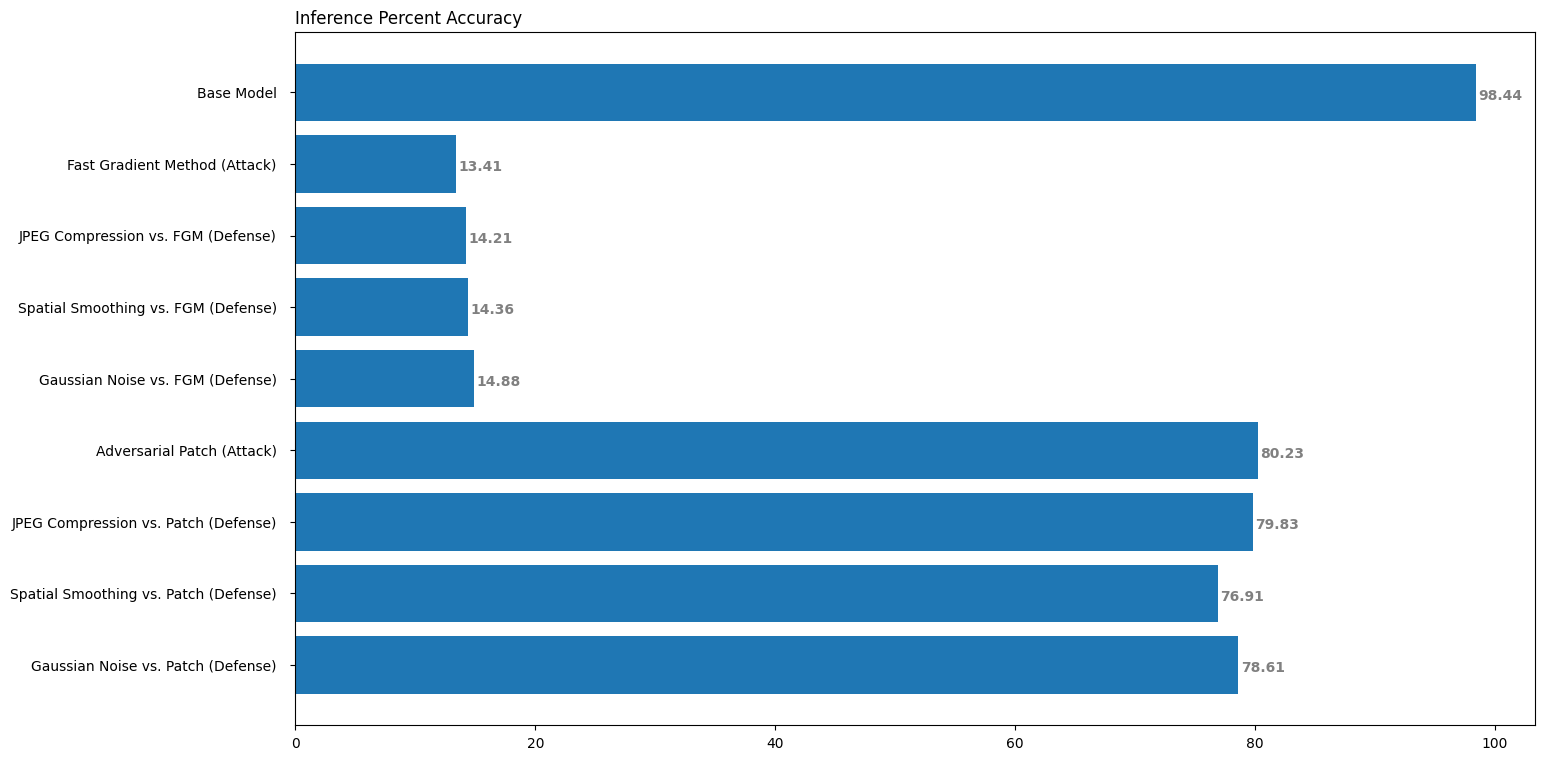

In [31]:
import numpy as np
import matplotlib.pyplot as plt 

scenarios = [
    'Base Model',
    'Fast Gradient Method (Attack)',
    'JPEG Compression vs. FGM (Defense)',
    'Spatial Smoothing vs. FGM (Defense)',
    'Gaussian Noise vs. FGM (Defense)',
    'Adversarial Patch (Attack)',
    'JPEG Compression vs. Patch (Defense)',
    'Spatial Smoothing vs. Patch (Defense)',
    'Gaussian Noise vs. Patch (Defense)'

]
values = [
    metrics['trained']['accuracy'] * 100,
    metrics['fgm']['accuracy'] * 100,
    metrics['jpeg_fgm']['accuracy'] * 100,
    metrics['spatial_fgm']['accuracy'] * 100,
    metrics['gaussian_fgm']['accuracy'] * 100,
    metrics['patch']['accuracy'] * 100,
    metrics['jpeg_patch']['accuracy'] * 100,
    metrics['spatial_patch']['accuracy'] * 100,
    metrics['gaussian_patch']['accuracy'] * 100,
]

fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(scenarios, values)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Show top values 
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Inference Percent Accuracy',
             loc ='left', )

# Show Plot
plt.show()